In [14]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
# Hyperparameters
random_seed = 123
generator_learning_rate = 0.001
discriminator_learning_rate = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 128
LATENT_DIM = 75
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x

In [5]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Failed to download (trying next):
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

Processing...


C:\Users\Selim\anaconda3\envs\ML\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [6]:
class GAN(torch.nn.Module):

    def __init__(self):
        super(GAN, self).__init__()
        
        
        self.generator = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, IMG_SIZE),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Linear(IMG_SIZE, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = model.discriminator(img)
        return pred.view(-1)

In [7]:
torch.manual_seed(random_seed)

model = GAN()
model = model.to(device)

optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

In [13]:
start_time = time.time()    

discr_costs = []
gener_costs = []
for epoch in range(NUM_EPOCHS):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        
        
        features = (features - 0.5)*2.
        features = features.view(-1, IMG_SIZE).to(device) 
        targets = targets.to(device)

        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)
        
        # Train Generator
        # Make new images
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(z)
        
        # Loss for fooling the discriminator
        discr_pred = model.discriminator_forward(generated_features)
        
        gener_loss = F.binary_cross_entropy(discr_pred, valid)
        
        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()
        
        # Train Discriminator
               
        discr_pred_real = model.discriminator_forward(features.view(-1, IMG_SIZE))
        real_loss = F.binary_cross_entropy(discr_pred_real, valid)
        
        discr_pred_fake = model.discriminator_forward(generated_features.detach())
        fake_loss = F.binary_cross_entropy(discr_pred_fake, fake)
        
        discr_loss = 0.5*(real_loss + fake_loss)

        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()        
        
        discr_costs.append(discr_loss)
        gener_costs.append(gener_loss)
        
        
        # LOGGING
    print ('Epoch: %03d/%03d | Gen/Dis Loss: %.4f/%.4f' %(epoch+1, NUM_EPOCHS, gener_loss, discr_loss))


Epoch: 001/100 | Gen/Dis Loss: 0.8780/0.6200
Epoch: 002/100 | Gen/Dis Loss: 0.8794/0.5973
Epoch: 003/100 | Gen/Dis Loss: 0.8511/0.6071
Epoch: 004/100 | Gen/Dis Loss: 1.0333/0.6264
Epoch: 005/100 | Gen/Dis Loss: 0.7159/0.6279
Epoch: 006/100 | Gen/Dis Loss: 0.8605/0.6132
Epoch: 007/100 | Gen/Dis Loss: 0.8719/0.6235
Epoch: 008/100 | Gen/Dis Loss: 0.9022/0.6435
Epoch: 009/100 | Gen/Dis Loss: 0.9201/0.6812
Epoch: 010/100 | Gen/Dis Loss: 1.0513/0.5852
Epoch: 011/100 | Gen/Dis Loss: 1.0871/0.6171
Epoch: 012/100 | Gen/Dis Loss: 1.0841/0.6405
Epoch: 013/100 | Gen/Dis Loss: 0.8327/0.6144
Epoch: 014/100 | Gen/Dis Loss: 0.8413/0.6184
Epoch: 015/100 | Gen/Dis Loss: 0.9776/0.6429
Epoch: 016/100 | Gen/Dis Loss: 0.8496/0.6044
Epoch: 017/100 | Gen/Dis Loss: 0.9143/0.6491
Epoch: 018/100 | Gen/Dis Loss: 0.8434/0.6251
Epoch: 019/100 | Gen/Dis Loss: 0.7902/0.6306
Epoch: 020/100 | Gen/Dis Loss: 0.7576/0.6536
Epoch: 021/100 | Gen/Dis Loss: 0.8241/0.6334
Epoch: 022/100 | Gen/Dis Loss: 0.8201/0.6156
Epoch: 023

C:\Users\Selim\anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


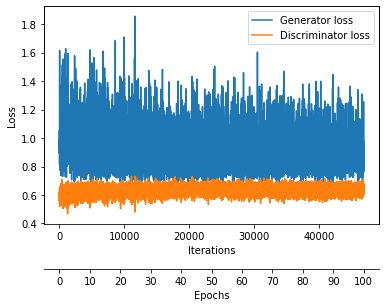

In [26]:
ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(gener_costs)), torch.tensor(gener_costs), label='Generator loss')
ax1.plot(range(len(discr_costs)), torch.tensor(discr_costs), label='Discriminator loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()



ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))
iter_per_epoch = len(train_loader)
newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticklabels(newlabel[::10])
ax2.set_xticks(newpos[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())


plt.show()

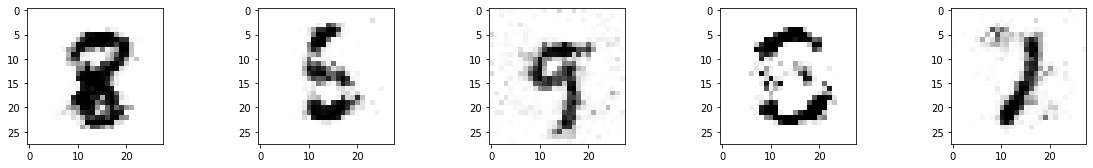

In [27]:
model.eval()

z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')
